<a href="https://colab.research.google.com/github/vavme/Binary-Salary-Range-Classification/blob/main/Binary_Salary_Classificaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Dasar
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#Bagging
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

#Boosting
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.model_selection import KFold # for cross validation
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV # for tuning parameter
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

In [ ]:
import seaborn as sns

In [ ]:
import warnings

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [ ]:
df = pd.read_csv('pendapatan_train.csv')

In [ ]:
#Mempersiapkan X_test
X_pred = pd.read_csv('pendapatan_test.csv')
X_pred = pd.get_dummies(X_pred, columns=['Kelas Pekerja','Pendidikan','Status Perkawinan','Pekerjaan','Jenis Kelamin'])
X_pred = X_pred.set_index('id')
X_pred.index

Int64Index([28794, 28795, 28796, 28797, 28798, 28799, 28800, 28801, 28802,
            28803,
            ...
            38383, 38384, 38385, 38386, 38387, 38388, 38389, 38390, 38391,
            38392],
           dtype='int64', name='id', length=9599)

In [ ]:
#Check Missing Value untuk Data Train
print(df.isna().any().any())
print(df.describe())

,id,Umur,Berat Akhir,Jmlh Tahun Pendidikan,Keuntungan Kapital,Kerugian Capital,Jam per Minggu
count,28794.000000,28794.000000,2.879400e+04,28794.000000,2.879400e+04,2.879400e+04,28794.000000
mean,14396.500000,38.557095,1.897640e+05,10.075919,1.547702e+07,1.221002e+06,40.398555
std,8312.256162,13.668667,1.047810e+05,2.561954,1.063346e+08,5.633757e+06,12.371845
min,0.000000,17.000000,1.349200e+04,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,7198.250000,28.000000,1.178668e+05,9.000000,0.000000e+00,0.000000e+00,40.000000
50%,14396.500000,37.000000,1.785235e+05,10.000000,0.000000e+00,0.000000e+00,40.000000
75%,21594.750000,48.000000,2.373860e+05,12.000000,0.000000e+00,0.000000e+00,45.000000
max,28793.000000,90.000000,1.490400e+06,16.000000,1.399986e+09,6.098400e+07,99.000000


In [ ]:
df = df.set_index('id')
df = pd.get_dummies(df, columns=['Kelas Pekerja','Pendidikan','Status Perkawinan','Pekerjaan','Jenis Kelamin'])

In [ ]:
df['Gaji'] = df['Gaji'].replace(
    {'<=7jt': 0,'>7jt' : 1})

In [ ]:
X = df.drop('Gaji',axis=1)

In [ ]:
y = df['Gaji']

In [ ]:
print(X.head())
print(y.head())

In [ ]:
#Memisahkan data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23035, 54) (23035,) (5759, 54) (5759,)


In [ ]:
#MengatasiImbalance Data
sm = SMOTE(sampling_strategy=0.4, k_neighbors=5, random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [ ]:
us = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_train, y_train = us.fit_sample(X_train, y_train)

In [ ]:
ALGS = [
    AdaBoostClassifier(random_state=42),
    BaggingClassifier(random_state=42),ExtraTreesClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),RandomForestClassifier(random_state=42),
    # LogisticRegressionCV(),
    KNeighborsClassifier(),
    SVC(random_state=42),
    XGBClassifier(random_state=42),
    CatBoostClassifier(silent=True, random_state=42),
    LGBMClassifier(random_state=42)
    ]

ALGS_columns = ['Nama Algoritma', 'Parameter Algoritma', 'Rata-rata Makro F1']
ALGS_compare = pd.DataFrame(columns = ALGS_columns)

ALGS_predict = pd.DataFrame()
row_index = 0
for alg in ALGS:
    ALGS_name = alg.__class__.__name__
    ALGS_compare.loc[row_index, 'Nama Algoritma'] = ALGS_name
    ALGS_compare.loc[row_index, 'Parameter Algoritma'] = str(alg.get_params())

    cv_results = cross_validate(alg, X_train, y_train, cv=10, scoring=metrics.make_scorer(metrics.f1_score, average='macro'))
#     print(cv_results)
    ALGS_compare.loc[row_index, 'Rata-rata Makro F1'] = cv_results['test_score'].mean()
    
    alg.fit(X_train, y_train)
    ALGS_predict[ALGS_name] = alg.predict(X_train)
    
    row_index+=1

In [ ]:
ALGS_compare.sort_values(by = ['Rata-rata Makro F1'], ascending = False, inplace = True)
ALGS_compare

,Nama Algoritma,Parameter Algoritma,Rata-rata Makro F1
9,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.846616
8,CatBoostClassifier,"{'silent': True, 'random_state': 42}",0.842816
7,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.825891
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.825127
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.823232
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.821629
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.808639
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.800802
5,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.69004
6,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.614811


In [ ]:
def tuning(alg, hyperparams):
    grid = GridSearchCV(alg, param_grid=hyperparams, scoring=metrics.make_scorer(metrics.f1_score, average='macro'), 
                           cv=10)
    grid.fit(X_train, y_train)

    print(grid.best_score_)
    print(grid.best_params_)
    print(grid.best_estimator_)

In [ ]:
def vis_cm(y_test,y_pred_val,title):
    """
    Show Confusion Matrix
    y_test = target label
    y_pred = predicted label
    title = title of confusion matrix
    """
    cm = metrics.confusion_matrix(y_test, y_pred_val)
    accuracy = np.trace(cm) / float(np.sum(cm))
    test_f1 = metrics.f1_score(y_test, y_pred_val,average='macro')
    print('Recall Non-default: {:.2f}%'.format(metrics.recall_score(y_test, y_pred_val, average="binary", pos_label=0)*100))
    print('Recall Default: {:.2f}%'.format(metrics.recall_score(y_test, y_pred_val, average="binary", pos_label=1)*100))
    print('Precision Non-default: {:.2f}%'.format(metrics.precision_score(y_test, y_pred_val, average="binary", pos_label=0)*100))
    print('Precision Default: {:.2f}%'.format(metrics.precision_score(y_test, y_pred_val, average="binary", pos_label=1)*100))

    misclass = 1 - accuracy

    # sns.set(font_scale=1.4) # for label size
    ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, linewidths=2, linecolor='black', fmt='g', cmap="Blues") # font size

    ax.set_xlabel('Predicted Label \nTest Accuracy={:0.4f}; Test Macro F1={:0.4f}'.format(accuracy, test_f1))
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix '+title)

    #static label agar tidak kurang
    labels=["Non-default", "Default"]
    ax.yaxis.set_ticklabels(labels)
    ax.xaxis.set_ticklabels(labels)

# LGBM

In [ ]:
lgbm = LGBMClassifier() 

hyperparams = {
    'learning_rate': [0.001, 0.002, 0.005],
    'n_estimators': [40,60,80,100],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [42], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
}
tuning(lgbm, hyperparams)

0.7527255818496705
{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 100, 'num_leaves': 16, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 1.2, 'reg_lambda': 1, 'subsample': 0.7}
LGBMClassifier(colsample_bytree=0.65, learning_rate=0.005, num_leaves=16,
               objective='binary', random_state=42, reg_alpha=1.2, reg_lambda=1,
               subsample=0.7)


In [ ]:
lgbm = LGBMClassifier(colsample_bytree=0.65, learning_rate=0.005, num_leaves=16,
               objective='binary', random_state=42, reg_alpha=1.2, reg_lambda=1,
               subsample=0.7)
lgbm.fit(X_train, y_train)
y_pred_val_lgbm = lgbm.predict(X_test)

Recall Non-default: 96.52%
Recall Default: 47.59%
Precision Non-default: 85.98%
Precision Default: 80.43%


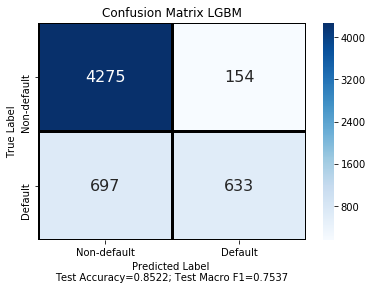

In [ ]:
vis_cm(y_test,y_pred_val_lgbm, 'LGBM')

# CatBoostClassifier

In [ ]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
cbc = CatBoostClassifier()

In [ ]:
randm = RandomizedSearchCV(estimator=cbc, param_distributions = parameters,
                               cv = 5, n_iter = 15, n_jobs=-1)
randm.fit(X_train, y_train)

0:	learn: 0.4811821	total: 15.5ms	remaining: 1.05s
1:	learn: 0.4262111	total: 30.9ms	remaining: 1.03s
2:	learn: 0.3969097	total: 47.5ms	remaining: 1.04s
3:	learn: 0.3771294	total: 73.3ms	remaining: 1.19s
4:	learn: 0.3674616	total: 91.2ms	remaining: 1.17s
5:	learn: 0.3606748	total: 125ms	remaining: 1.31s
6:	learn: 0.3555342	total: 161ms	remaining: 1.42s
7:	learn: 0.3512222	total: 177ms	remaining: 1.35s
8:	learn: 0.3472208	total: 213ms	remaining: 1.42s
9:	learn: 0.3443254	total: 231ms	remaining: 1.36s
10:	learn: 0.3407518	total: 263ms	remaining: 1.39s
11:	learn: 0.3385427	total: 283ms	remaining: 1.34s
12:	learn: 0.3349664	total: 317ms	remaining: 1.36s
13:	learn: 0.3319620	total: 335ms	remaining: 1.32s
14:	learn: 0.3304318	total: 363ms	remaining: 1.31s
15:	learn: 0.3241398	total: 385ms	remaining: 1.28s
16:	learn: 0.3227861	total: 426ms	remaining: 1.3s
17:	learn: 0.3195643	total: 446ms	remaining: 1.26s
18:	learn: 0.3185898	total: 476ms	remaining: 1.25s
19:	learn: 0.3171365	total: 490ms	rem

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000022301610208>,
                   n_iter=15, n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000223015327B8>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000223016EDA58>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022301610048>})

In [ ]:
parameters = {'depth'         : sp_randInt(4, 10),
                  'learning_rate' : sp_randFloat(),
                  'iterations'    : sp_randInt(10, 100)
                 }

In [ ]:
print(randm.best_params_)

{'depth': 5, 'iterations': 69, 'learning_rate': 0.3663618432936917}


CatBoostClassifier

In [ ]:
cbc_tuned = CatBoostClassifier(depth = 5, iterations = 69, learning_rate =  0.3663618432936917)

In [ ]:
cbc_tuned.fit(X_train, y_train)
y_pred_val_cbc = cbc_tuned.predict(X_test)

0:	learn: 0.4811821	total: 26ms	remaining: 1.77s
1:	learn: 0.4262111	total: 40.8ms	remaining: 1.37s
2:	learn: 0.3969097	total: 55.6ms	remaining: 1.22s
3:	learn: 0.3771294	total: 71.5ms	remaining: 1.16s
4:	learn: 0.3674616	total: 85.9ms	remaining: 1.1s
5:	learn: 0.3606748	total: 101ms	remaining: 1.06s
6:	learn: 0.3555342	total: 115ms	remaining: 1.02s
7:	learn: 0.3512222	total: 130ms	remaining: 990ms
8:	learn: 0.3472208	total: 145ms	remaining: 964ms
9:	learn: 0.3443254	total: 159ms	remaining: 940ms
10:	learn: 0.3407518	total: 174ms	remaining: 916ms
11:	learn: 0.3385427	total: 188ms	remaining: 894ms
12:	learn: 0.3349664	total: 203ms	remaining: 873ms
13:	learn: 0.3319620	total: 217ms	remaining: 852ms
14:	learn: 0.3304318	total: 241ms	remaining: 867ms
15:	learn: 0.3241398	total: 257ms	remaining: 852ms
16:	learn: 0.3227861	total: 278ms	remaining: 852ms
17:	learn: 0.3195643	total: 295ms	remaining: 835ms
18:	learn: 0.3185898	total: 311ms	remaining: 818ms
19:	learn: 0.3171365	total: 326ms	remai

Recall Non-default: 89.68%
Recall Default: 75.49%
Precision Non-default: 92.42%
Precision Default: 68.72%


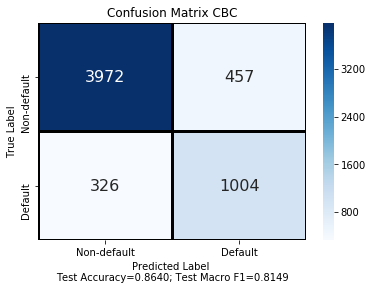

In [ ]:
vis_cm(y_test,y_pred_val_cbc, 'CBC')

Recall Non-default: 89.82%
Recall Default: 75.19%
Precision Non-default: 92.34%
Precision Default: 68.92%


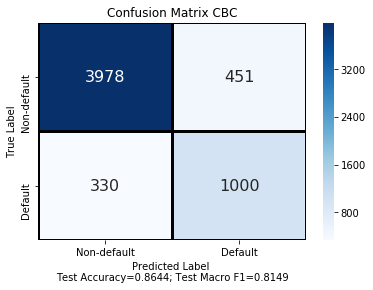

In [ ]:
vis_cm(y_test,y_pred_val_cbc, 'CBC')

# XGBClassifier

In [ ]:
import xgboost as xgb

In [ ]:
sp_randFloat(0.1,0.01)

In [ ]:
xgbc = XGBClassifier()

In [ ]:
sp_randFloat?

In [ ]:
xgbc_params = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate' : [0.1, 0.07 ,0.05, 0.03, 0.01],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'colsample_bytree': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
    'gamma' : [0,1,5]
}

In [ ]:
randm_xgbc = RandomizedSearchCV(estimator=xgbc, param_distributions = xgbc_params,
                               cv = 5, n_iter = 10, n_jobs=-1)

In [ ]:
randm_xgbc.fit(X_train, y_train)
print(randm_xgbc.best_params_)

{'subsample': 1, 'max_depth': 5, 'learning_rate': 0.07, 'gamma': 0, 'colsample_bytree': 0.5}


In [ ]:
print(randm_xgbc.best_params_)

{'subsample': 1, 'max_depth': 5, 'learning_rate': 0.07, 'gamma': 0, 'colsample_bytree': 0.5}


In [ ]:
xgbc_tuned = XGBClassifier(subsample= 0.95, max_depth= 6, learning_rate= 0.1, gamma= 5, colsample_bytree= 0.6)

In [ ]:
xgbc_tuned.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.5, learning_rate=0.07, max_depth=5)

In [ ]:
y_pred_test = xgbc_tuned.predict(X_test)

Recall Non-default: 89.39%
Recall Default: 74.59%
Precision Non-default: 92.13%
Precision Default: 67.85%


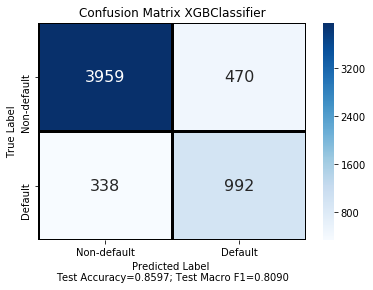

In [ ]:
vis_cm(y_test,y_pred_test, 'XGBClassifier')

Recall Non-default: 89.75%
Recall Default: 75.79%
Precision Non-default: 92.51%
Precision Default: 68.95%


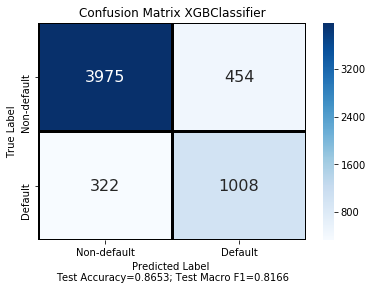

In [ ]:
vis_cm(y_test,y_pred_test, 'XGBClassifier')

# Feature Importance

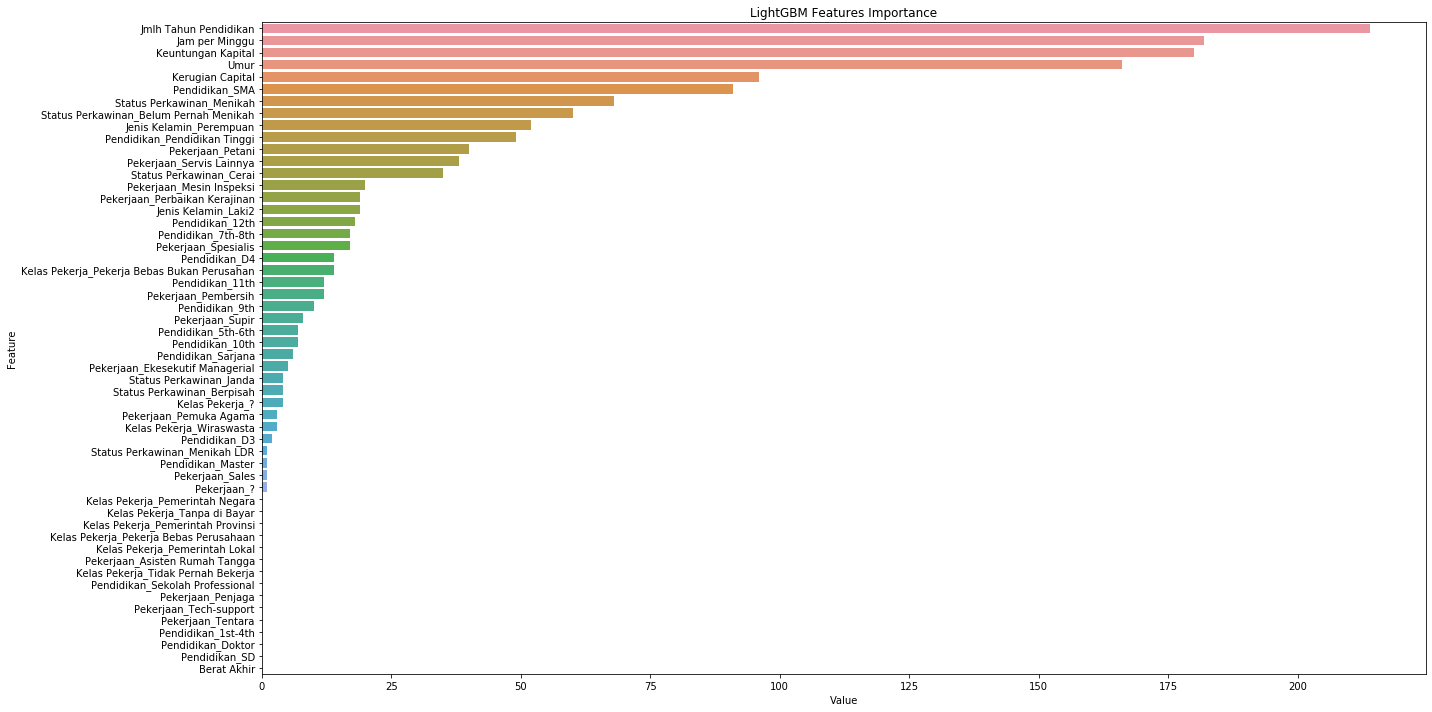

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.show()

In [ ]:
df_fi_lgbm = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])
# df_fi_rf['Feature'][15:]
df_fi_lgbm.tail(13)

df_fi_list = df_fi_lgbm.tail(20)

lgbm_fi = df_fi_list['Feature'].tolist()

,Value,Feature
41,35,Status Perkawinan_Cerai
42,38,Pekerjaan_Servis Lainnya
43,40,Pekerjaan_Petani
44,49,Pendidikan_Pendidikan Tinggi
45,52,Jenis Kelamin_Perempuan
46,60,Status Perkawinan_Belum Pernah Menikah
47,68,Status Perkawinan_Menikah
48,91,Pendidikan_SMA
49,96,Kerugian Capital
50,166,Umur


In [ ]:
X_train_filter_fi_lgbm = X_train[lgbm_fi]
X_test_filter_fi_lgbm = X_test[lgbm_fi]

In [ ]:
lgbm = LGBMClassifier(colsample_bytree=0.65, learning_rate=0.005, num_leaves=16,
               objective='binary', random_state=42, reg_alpha=1.2, reg_lambda=1,
               subsample=0.7)
lgbm.fit(X_train_filter_fi_lgbm, y_train)
y_pred_val_lgbm = lgbm.predict(X_test_filter_fi_lgbm)

Recall Non-default: 96.66%
Recall Default: 47.52%
Precision Non-default: 85.98%
Precision Default: 81.03%


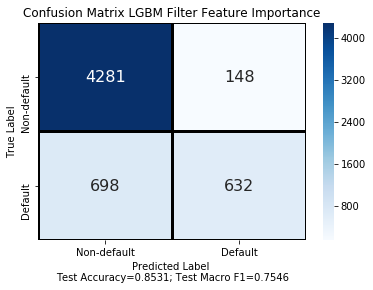

In [ ]:
vis_cm(y_test,y_pred_val_lgbm, 'LGBM Filter Feature Importance')

In [ ]:
X_pred_filter_fi_lgbm = X_pred[lgbm_fi]

In [ ]:
y_pred = lgbm.predict(X_pred_filter_fi_lgbm)

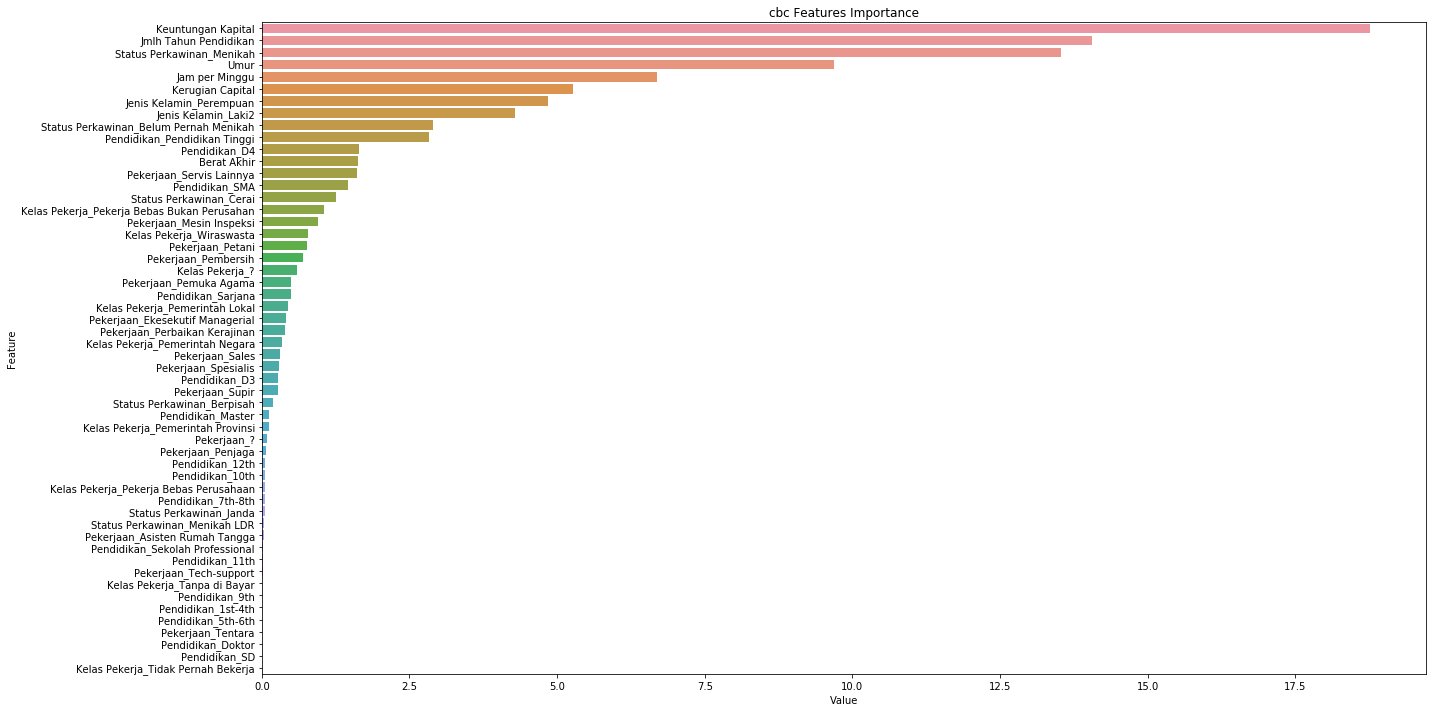

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(cbc_tuned.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('cbc Features Importance')
plt.tight_layout()
plt.show()

In [ ]:
df_fi_cbc = pd.DataFrame(sorted(zip(cbc_tuned.feature_importances_,X_train.columns)), columns=['Value','Feature'])
# df_fi_rf['Feature'][15:]
df_fi_cbc.tail(20)

df_fi_list = df_fi_cbc.tail(15)

cbc_fi = df_fi_list['Feature'].tolist()

In [ ]:
X_train_filter_fi_lgbm = X_train[lgbm_fi]
X_test_filter_fi_lgbm = X_test[lgbm_fi]

In [ ]:
cbc_tuned.fit(X_train_filter_fi_lgbm, y_train)
y_pred_val_cbc = cbc_tuned.predict(X_test_filter_fi_lgbm)

0:	learn: 0.5020942	total: 15.7ms	remaining: 1.07s
1:	learn: 0.4242830	total: 32ms	remaining: 1.07s
2:	learn: 0.4017189	total: 44.8ms	remaining: 986ms
3:	learn: 0.3873289	total: 58.7ms	remaining: 954ms
4:	learn: 0.3773365	total: 73.2ms	remaining: 937ms
5:	learn: 0.3710210	total: 88.7ms	remaining: 931ms
6:	learn: 0.3576665	total: 102ms	remaining: 907ms
7:	learn: 0.3522097	total: 116ms	remaining: 885ms
8:	learn: 0.3489202	total: 131ms	remaining: 873ms
9:	learn: 0.3468368	total: 145ms	remaining: 854ms
10:	learn: 0.3434938	total: 160ms	remaining: 844ms
11:	learn: 0.3407521	total: 174ms	remaining: 825ms
12:	learn: 0.3388608	total: 188ms	remaining: 812ms
13:	learn: 0.3368156	total: 202ms	remaining: 795ms
14:	learn: 0.3353018	total: 219ms	remaining: 787ms
15:	learn: 0.3342734	total: 233ms	remaining: 773ms
16:	learn: 0.3327078	total: 251ms	remaining: 767ms
17:	learn: 0.3315674	total: 269ms	remaining: 762ms
18:	learn: 0.3287197	total: 285ms	remaining: 749ms
19:	learn: 0.3268891	total: 299ms	rem

Recall Non-default: 88.96%
Recall Default: 74.89%
Precision Non-default: 92.19%
Precision Default: 67.07%


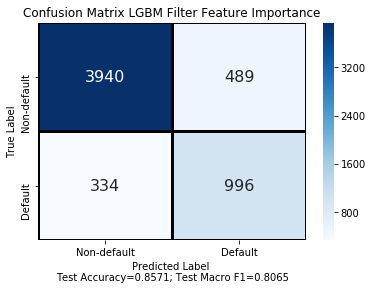

In [ ]:
vis_cm(y_test,y_pred_val_cbc, 'LGBM Filter Feature Importance')

In [ ]:
df_fi_xgbc = pd.DataFrame(sorted(zip(xgbc_tuned.feature_importances_,X_train.columns)), columns=['Value','Feature'])
# df_fi_rf['Feature'][15:]
df_fi_xgbc.tail(20)

df_fi_list = df_fi_xgbc.tail(15)

xgbc_fi = df_fi_list['Feature'].tolist()

In [ ]:
X_train_filter_fi_xgbc = X_train[xgbc_fi]
X_test_filter_fi_xgbc = X_test[xgbc_fi]

In [ ]:
xgbc_tuned.fit(X_train_filter_fi_xgbc, y_train)
y_pred_val_xgbc = xgbc_tuned.predict(X_test_filter_fi_xgbc)

Recall Non-default: 89.03%
Recall Default: 73.61%
Precision Non-default: 91.83%
Precision Default: 66.83%


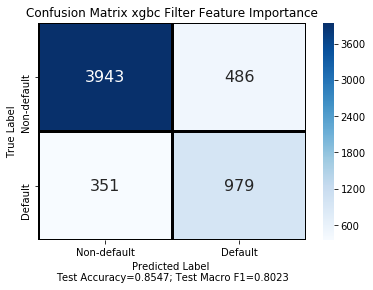

In [ ]:
vis_cm(y_test,y_pred_val_xgbc, 'xgbc Filter Feature Importance')

In [ ]:
np.random.seed(42)
grid_soft = VotingClassifier(estimators = [('LGBM', lgbm), 
                                           ('CBC', cbc_tuned),
                                           ('XGBC', xgbc_tuned)
                                          ], voting = 'soft')
grid_soft.fit(X_train, y_train)
y_pred_val_soft_voting = grid_soft.predict(X_test)

0:	learn: 0.4811821	total: 15.1ms	remaining: 1.02s
1:	learn: 0.4262111	total: 31.8ms	remaining: 1.07s
2:	learn: 0.3969097	total: 47.6ms	remaining: 1.05s
3:	learn: 0.3771294	total: 62.2ms	remaining: 1.01s
4:	learn: 0.3674616	total: 76.8ms	remaining: 983ms
5:	learn: 0.3606748	total: 91.4ms	remaining: 960ms
6:	learn: 0.3555342	total: 106ms	remaining: 942ms
7:	learn: 0.3512222	total: 121ms	remaining: 922ms
8:	learn: 0.3472208	total: 136ms	remaining: 904ms
9:	learn: 0.3443254	total: 150ms	remaining: 884ms
10:	learn: 0.3407518	total: 164ms	remaining: 866ms
11:	learn: 0.3385427	total: 179ms	remaining: 849ms
12:	learn: 0.3349664	total: 193ms	remaining: 833ms
13:	learn: 0.3319620	total: 212ms	remaining: 834ms
14:	learn: 0.3304318	total: 240ms	remaining: 865ms
15:	learn: 0.3241398	total: 257ms	remaining: 852ms
16:	learn: 0.3227861	total: 274ms	remaining: 838ms
17:	learn: 0.3195643	total: 290ms	remaining: 821ms
18:	learn: 0.3185898	total: 305ms	remaining: 803ms
19:	learn: 0.3171365	total: 319ms	r

Recall Non-default: 91.31%
Recall Default: 72.03%
Precision Non-default: 91.58%
Precision Default: 71.33%


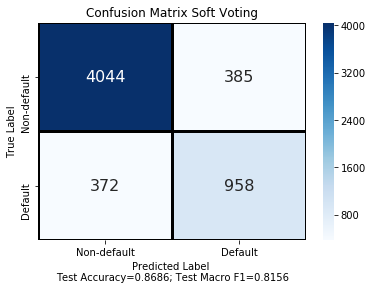

In [ ]:
vis_cm(y_test,y_pred_val_soft_voting, 'Soft Voting')

In [ ]:
np.random.seed(42)
grid_hard = VotingClassifier(estimators = [('LGBM', lgbm), 
                                           ('CBC', cbc_tuned),
                                           ('XGBC', xgbc_tuned)
                                          ], voting = 'hard')
grid_hard.fit(X_train, y_train)
y_pred_val_hard_voting = grid_hard.predict(X_test)

0:	learn: 0.4811821	total: 15.3ms	remaining: 1.04s
1:	learn: 0.4262111	total: 30.5ms	remaining: 1.02s
2:	learn: 0.3969097	total: 44.9ms	remaining: 989ms
3:	learn: 0.3771294	total: 62.5ms	remaining: 1.01s
4:	learn: 0.3674616	total: 77ms	remaining: 985ms
5:	learn: 0.3606748	total: 91.9ms	remaining: 965ms
6:	learn: 0.3555342	total: 106ms	remaining: 942ms
7:	learn: 0.3512222	total: 122ms	remaining: 928ms
8:	learn: 0.3472208	total: 136ms	remaining: 908ms
9:	learn: 0.3443254	total: 151ms	remaining: 891ms
10:	learn: 0.3407518	total: 165ms	remaining: 871ms
11:	learn: 0.3385427	total: 180ms	remaining: 854ms
12:	learn: 0.3349664	total: 194ms	remaining: 837ms
13:	learn: 0.3319620	total: 212ms	remaining: 833ms
14:	learn: 0.3304318	total: 236ms	remaining: 851ms
15:	learn: 0.3241398	total: 251ms	remaining: 833ms
16:	learn: 0.3227861	total: 267ms	remaining: 815ms
17:	learn: 0.3195643	total: 282ms	remaining: 800ms
18:	learn: 0.3185898	total: 304ms	remaining: 800ms
19:	learn: 0.3171365	total: 320ms	rem

Recall Non-default: 90.99%
Recall Default: 73.46%
Precision Non-default: 91.95%
Precision Default: 71.00%


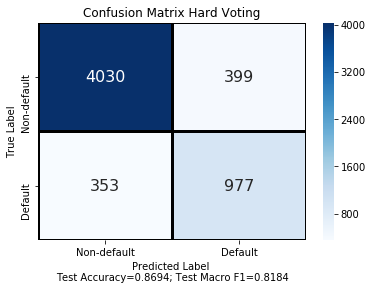

In [ ]:
vis_cm(y_test,y_pred_val_hard_voting, 'Hard Voting')

In [ ]:
y_pred = grid_hard.predict(X_pred)

In [ ]:
y_pred = pd.DataFrame(y_pred).set_index(X_pred.index)
y_pred = y_pred.rename(columns = {0:'Gaji'})

In [ ]:
y_pred.to_csv('submission6.csv', index=True)